## network analysis and frekans analysis for DEU site

### import libraries

In [92]:
from bs4 import BeautifulSoup
from requests.exceptions import SSLError
import requests
import csv
import os
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import networkx as nx
import matplotlib.colors as mcolors

### Data scraping

In [93]:
url = "https://www.deu.edu.tr/"
header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
}

In [94]:
def GetPage(Link,FileName, header) : 
    page = requests.get(Link, headers=header)
    soup = BeautifulSoup(page.content, 'html.parser')
    print(f'Number of paragraphs is :  {len(soup.find_all("p"))}')
    try : 
        title = soup.find(id="firstHeading")
        print(f'Page title is :   {title.string}')
    except:
        pass
    if len(soup.find_all('p')) ==0 : return None
    f = open(FileName,'w',encoding = 'utf-8')
    for i in range(len(soup.find_all('p'))) : 
        f.write(soup.find_all('p')[i].get_text())
        f.write('\n')
    f.close()
    return soup

In [95]:
soup = GetPage(url,'data.txt',header)

Number of paragraphs is :  25


In [96]:
links = []
for link in soup.find_all("a"):
    href = link.get('href')
    if href and not href.startswith('#')and "deu.edu.tr" in href:
        if not href.startswith('http'):
            href = url + href
            links.append(href)
        else:
            links.append(href)

In [97]:
links = list(set(links))

In [98]:
len(links)

279

## 1- Sözcük frekans analizi ve görselleştirmesi

### Export data into text files

In [100]:
# bütün linkleri dolaşıp sayfayı okuyup ayrı dosyalara yazma işlemleri
data = [] 
i = 1
for link in links[:100]:
    try:
        response = requests.get(link, headers=header)
    except:
        pass
    if response.status_code != 200: # bağlantıda sorun olursa sonraki döngüye döneceğini sağlar 
        continue
    else:
        soup = BeautifulSoup(response.content, 'html.parser')
        text_data = []
        for element in soup.find_all(['p', 'h1', 'h2', 'h3', 'ul', 'ol', 'li']):
            text_data.append(element.text.strip())
        data.extend(text_data)
        for text in data:
            with open(f'{i}.txt', 'w', newline='', encoding='utf-8') as file:
                for text in data:
                    file.write(text + '\n')
        i = i + 1
        soup.clear()
        del response
        data = [] #her sayfa ayri bir dosyada tutmak için döngü bitiğinde matrisi sıfırlar

NameError: name 'response' is not defined

### Read data into dataframe

In [101]:
path_3 = "C:/Users/ALAAEDDIN" # txt dosyalar olduğu lokasyon

In [102]:
def read_txt_files(path):
    txt_list = []
    for f_name in os.listdir(path):
        if f_name.endswith(".txt"):
            with open(os.path.join(path, f_name), "r", encoding="utf-8") as f:
                t = f.read()
                txt_list.append(t)
                df = pd.DataFrame(txt_list, columns=["txt"])
    return df

### Convert to lowercase

In [103]:
df = read_txt_files(path_3)

In [104]:
df["txt"] = df["txt"].str.lower()

### Delete punctuation marks

In [105]:
import string

def delete_punctuation(st):
    punctuations = string.punctuation
    no_punct = ""
    for char in st:
        if char not in punctuations:
            no_punct += char

    return no_punct

df["txt"] = df["txt"].apply(lambda x: delete_punctuation(x))

### Delete \n and number and other marks

In [106]:
import re

def remove_n_line(text):
    return re.sub(r'\n(?!n\w)', ' ', text)

df['txt'] = df['txt'].apply(remove_n_line)

In [107]:
def remove_number(text):
    return re.sub(r'\d+', ' ', text)
df["txt"] = df["txt"].apply(remove_number)

In [108]:
def remove_sembol(text):
    return re.sub(r'[-:,’–"".]+', ' ', text)
df["txt"] = df["txt"].apply(remove_sembol)

In [109]:
df.head()

,txt
0,beğenitakipçitakipçi beğeni takipçi takipçi d...
1,araştırmacı girişi ...
2,ana sayfa hakkımızda organizasyon yapımız b...
3,engelsiz anasayfa mezun debi̇s personel eposta...
4,twitter deü twitter deü anasayfa kurumsal ü...


In [110]:
df.tail()

,txt
34,anasayfa hakkımızda yönetim yönetim kurulu ü...
35,beğenitakipçitakipçi beğeni takipçi takipçi d...
36,beğenitakipçitakipçi beğeni takipçi takipçi d...
37,dokuz eylül üni̇versi̇tesi̇ rektörlüğü cumhuri...
38,beğenitakipçitakipçi beğeni takipçi takipçi d...


### Tokenizetion

In [111]:
df["word"] = df["txt"].apply(lambda x :word_tokenize(x))

###   delete of Stop word

In [112]:
def read_txt_file_to_list(path, name):
    list = []
    with open(os.path.join(path, name), "r", encoding="utf-8") as f:
        for i in f:
            list.append(i.strip())
    return list
stop_word_1 = read_txt_file_to_list("C:/Users/ALAAEDDIN/PycharmProjects/pythonProject2/raw_texts", "stop-words_turkish_1_tr.txt")
stop_word_1 = stop_word_1[3:]
df["word"] = df["word"].apply(lambda x: [item for item in x if item not in stop_word_1])

In [113]:
df.head()

,txt,word
0,beğenitakipçitakipçi beğeni takipçi takipçi d...,"[beğenitakipçitakipçi, beğeni, takipçi, takipç..."
1,araştırmacı girişi ...,"[araştırmacı, girişi, english, araştırmacı, gi..."
2,ana sayfa hakkımızda organizasyon yapımız b...,"[ana, sayfa, hakkımızda, organizasyon, yapımız..."
3,engelsiz anasayfa mezun debi̇s personel eposta...,"[engelsiz, anasayfa, mezun, debi̇s, personel, ..."
4,twitter deü twitter deü anasayfa kurumsal ü...,"[twitter, deü, twitter, deü, anasayfa, kurumsa..."


In [114]:
all_word = []
for i in range(0,len(df)):
    all_word += df.loc[i,"word"]

In [115]:
len(all_word)

34105

In [116]:
unique_word = list(set(all_word)) #sete çevirmek tekrarlayan kalime varsa silinir böylece unique kalimeleri elde ediyoruz

In [117]:
len(unique_word)

5305

In [118]:
# frekans ve kalimenin geçtiği sayfa sayısı hesaplayan kod parçası 
word_freq = {}
flag = False
for word in unique_word:
        word_freq[word] = {'frequency': 0, 'files': 0}
        for i in range(0,len(df)):
            flag = False
            for j in df.loc[i,"word"]:
                if j==word:
                    flag = True
                    word_freq[word]['frequency'] += 1
            if flag:
                word_freq[word]['files'] += 1

In [119]:
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1]["frequency"], reverse=True)

In [120]:
sorted_word_freq[:10]

[('araştırma', {'frequency': 705, 'files': 24}),
 ('uygulama', {'frequency': 551, 'files': 16}),
 ('merkezi', {'frequency': 508, 'files': 7}),
 ('deü', {'frequency': 485, 'files': 22}),
 ('eylül', {'frequency': 330, 'files': 29}),
 ('formu', {'frequency': 230, 'files': 16}),
 ('akademik', {'frequency': 218, 'files': 23}),
 ('öğrenci', {'frequency': 215, 'files': 16}),
 ('fakültesi', {'frequency': 204, 'files': 11}),
 ('meslek', {'frequency': 174, 'files': 19})]

In [121]:
only_word_freq = [(key, value['frequency']) for key, value in sorted_word_freq]

## Visualization

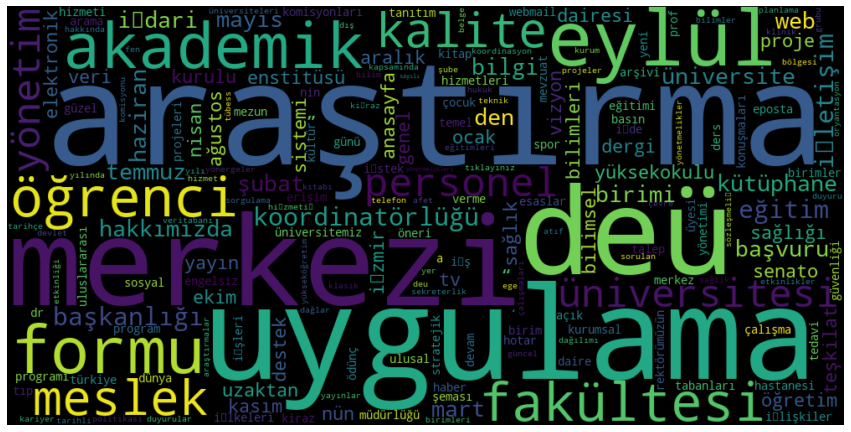

In [122]:
wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(dict(only_word_freq))
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file("wordcloud_output.png")

In [123]:
df_fre = pd.DataFrame(sorted_word_freq, columns=['word', 'data'])
df_fre['frequency'] = df_fre['data'].apply(lambda x: x['frequency'])
df_fre['files'] = df_fre['data'].apply(lambda x: x['files'])
df_fre.drop('data', axis=1, inplace=True)

In [124]:
df_fre.head(10)

,word,frequency,files
0,araştırma,705,24
1,uygulama,551,16
2,merkezi,508,7
3,deü,485,22
4,eylül,330,29
5,formu,230,16
6,akademik,218,23
7,öğrenci,215,16
8,fakültesi,204,11
9,meslek,174,19


In [125]:
df_fre.to_csv("C:/Users/ALAAEDDIN/deu_text/df_fre.csv",index=False)

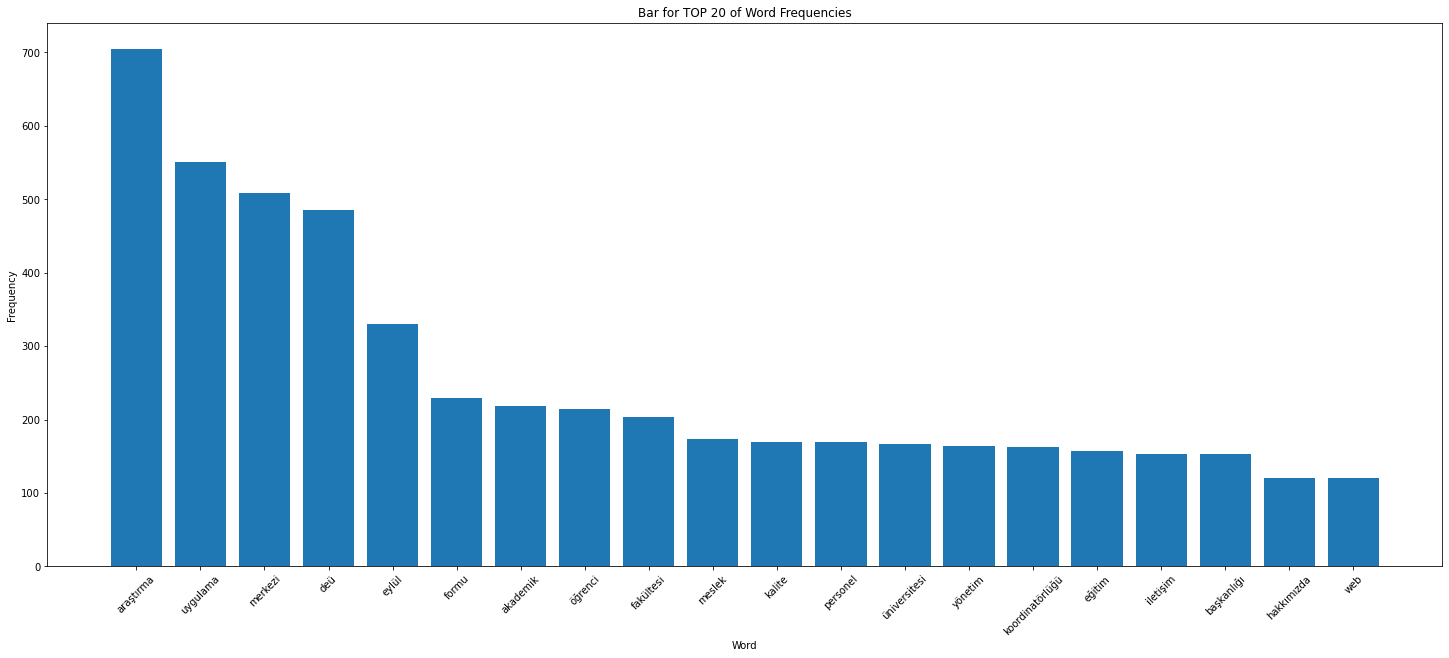

In [126]:
plt.figure(figsize=(25, 10))
fig = plt.bar(df_fre['word'][:20], df_fre['frequency'][:20])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Bar for TOP 20 of Word Frequencies')
plt.xticks(rotation=45)
plt.show()

## 2- Web sayfaları bazlı centrality analizi ve Görselleştirmesi

### Data scraping

In [127]:
# ana sayfadan başlayarak alt sayfalara giden ve ağ analizine uyacak şekilde data yapısını hazırlayan kod parçası biraz zaman alıyor
# çalıştırınca bu yüzden depth paramitersi ekledim sadece 2 seviye bir derinlik alsın diye ancak yine de yaklaşık beş dakika zaman alır
links_cen = []
visited_link = []
root_Link = "https://www.deu.edu.tr/"
header = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
}
def get_links_for_centrality(root_Link, link_matris, header,vizited_links, depth=0,dep_max=2):
    if depth >= dep_max:
        return link_matris
    try:
        page = requests.get(root_Link, headers=header)
    except:
        print(f"Error accessing link: {root_Link}")
        return link_matris
    vizited_links.append(root_Link)
    soup = BeautifulSoup(page.content, 'html.parser')
    for link in soup.find_all("a"):
        href = link.get('href')
        if href and not href.startswith('#'):
            if not href.startswith('http'):
                href = root_Link + href
            if href != root_Link and href not in vizited_links and "deu.edu.tr" in href:
                link_matris.append((root_Link, href))
                get_links_for_centrality(href, link_matris, header,vizited_links, depth+1, dep_max)
    return link_matris

links_cen = get_links_for_centrality(root_Link, links_cen, header, visited_link)


Error accessing link: https://webmail.deu.edu.tr/ogrmail/src/login.php


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Error accessing link: https://webmail.deu.edu.tr/ogrmail/src/login.php
Error accessing link: https://webmail.deu.edu.tr/kail/src/login.php
Error accessing link: https://webmail.deu.edu.tr/kail/src/login.php
Error accessing link: https://webmail.deu.edu.tr/ogrmail/src/login.php
Error accessing link: https://webmail.deu.edu.tr/kail/src/login.php


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Error accessing link: http://iramer.deu.edu.tr/


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [128]:
len(links_cen)

25798

In [129]:
G = nx.Graph()

In [130]:
for link in links_cen[:2500]: # linklerin saysısı çok fazla olduğu için sadece 2500sı daha fazla alınca graf gösteremedim
    G.add_edge(link[0], link[1])

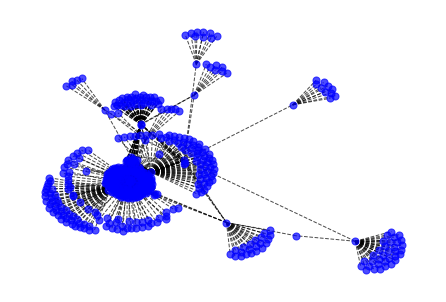

In [131]:
nx.draw(G, with_labels=False, node_color='blue',edge_color='black', node_size=50, alpha=0.7,style='dashed')
plt.show()

### Degree centrality

In [132]:
degree_centrality = nx.degree_centrality(G)

In [133]:
degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True) # sorting işlemi
df_degree_centrality = pd.DataFrame(degree_centrality, columns=['node', 'degree']) # data frame'e çevirmek 

In [134]:
df_degree_centrality.head()

,node,degree
0,https://www.deu.edu.tr/yonergeler/,0.528302
1,https://www.deu.edu.tr/uygulama-ve-arastirma-m...,0.482180
2,https://www.deu.edu.tr/esaslar/,0.433962
3,https://www.deu.edu.tr/yonetmelikler/,0.412998
4,https://www.deu.edu.tr/bilgi-guvenligi-politik...,0.402516


In [135]:
df_degree_centrality.tail()

,node,degree
473,https://www.deu.edu.tr/esaslar/javascript:void...,0.002096
474,https://www.deu.edu.tr/akademik-teskilat-semas...,0.002096
475,https://www.deu.edu.tr/file/2023/02/05022023DE...,0.002096
476,https://www.deu.edu.tr/akademik-teskilat-semas...,0.002096
477,https://www.deu.edu.tr/akademik-teskilat-semas...,0.002096


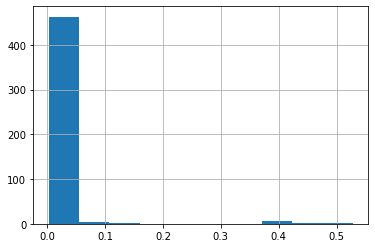

In [136]:
df_degree_centrality["degree"].hist()
plt.show()

### Betweeness centrality

In [137]:
betweenness = nx.betweenness_centrality(G)

In [138]:
betweenness_centrality = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
df_betweenness_centrality = pd.DataFrame(betweenness_centrality, columns=['node', 'betweenness'])

In [139]:
df_betweenness_centrality.head()

,node,betweenness
0,https://www.deu.edu.tr/yonergeler/,0.283252
1,https://www.deu.edu.tr/,0.274175
2,https://www.deu.edu.tr/uygulama-ve-arastirma-m...,0.200989
3,https://global.deu.edu.tr/,0.134581
4,https://www.deu.edu.tr/esaslar/,0.110428


In [140]:
df_betweenness_centrality.tail()

,node,betweenness
473,https://www.deu.edu.tr/esaslar/javascript:void...,0.0
474,https://www.deu.edu.tr/akademik-teskilat-semas...,0.0
475,https://www.deu.edu.tr/file/2023/02/05022023DE...,0.0
476,https://www.deu.edu.tr/akademik-teskilat-semas...,0.0
477,https://www.deu.edu.tr/akademik-teskilat-semas...,0.0


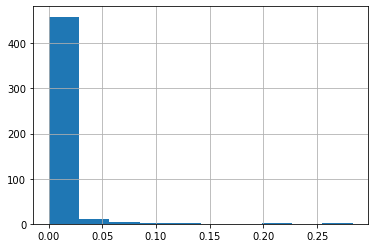

In [141]:
df_betweenness_centrality["betweenness"].hist()
plt.show()

### Closeness centrality

In [142]:
closeness = nx.closeness_centrality(G)

In [143]:
closeness_centrality = sorted(closeness.items(), key=lambda x: x[1], reverse=True)
df_closeness_centrality = pd.DataFrame(closeness_centrality, columns=['node', 'closeness'])

In [144]:
df_closeness_centrality.head()

,node,closeness
0,https://www.deu.edu.tr/yonergeler/,0.580999
1,https://www.deu.edu.tr/uygulama-ve-arastirma-m...,0.565836
2,https://www.deu.edu.tr/esaslar/,0.550808
3,https://www.deu.edu.tr/yonetmelikler/,0.544521
4,https://www.deu.edu.tr/bilgi-guvenligi-politik...,0.537162


In [145]:
df_closeness_centrality.tail()

,node,closeness
473,https://mezun.deu.edu.tr/iletisim/,0.254536
474,https://mezun.deu.edu.tr/mezun-kart/,0.254536
475,https://mezun.deu.edu.tr/giris/,0.254536
476,https://mezun.deu.edu.tr/eski-mezun-basvuru/,0.254536
477,https://mezun.deu.edu.tr/mezun-bilgi-formu/,0.254536


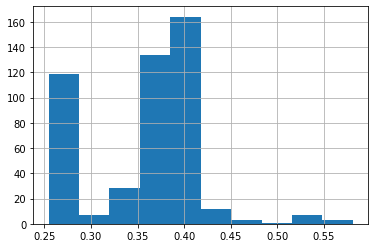

In [146]:
df_closeness_centrality["closeness"].hist()
plt.show()

In [147]:
pos = nx.spring_layout(G, seed=500)

In [154]:
def draw(G, pos, measures, measure_name, output_path):
    plt.figure(figsize=(10, 6))

    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes, label=measure_name)
    plt.axis('off')
    plt.savefig(output_path)
    plt.show()

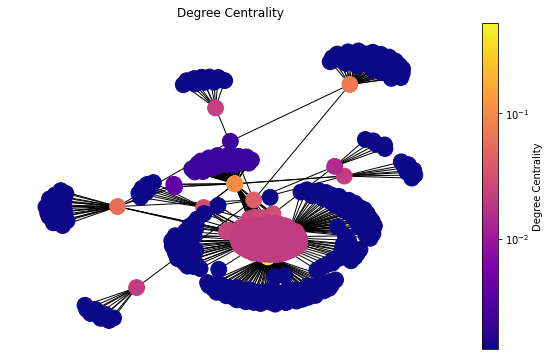

In [157]:
draw(G, pos, nx.degree_centrality(G), "Degree Centrality", "C:/Users/ALAAEDDIN/Degree.png")

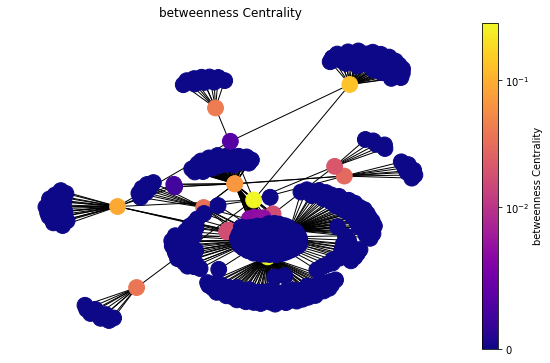

In [158]:
draw(G, pos, nx.betweenness_centrality(G), 'betweenness Centrality', "C:/Users/ALAAEDDIN/betweenness.png")

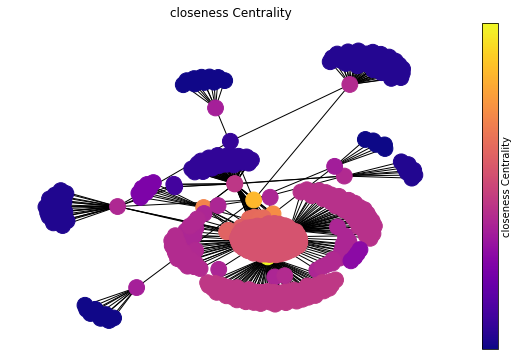

In [159]:
draw(G, pos, nx.closeness_centrality(G), 'closeness Centrality', "C:/Users/ALAAEDDIN/closeness.png")